In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
%matplotlib inline

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

### Data loading

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
input_dim = 784
output_dim = 10

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Data visualization

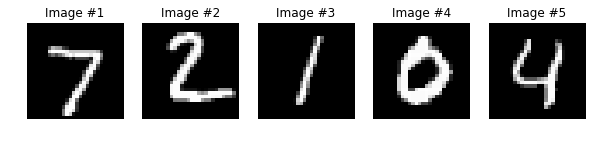

In [3]:
no_plot_img = 5
plt.rcParams['figure.figsize'] = (10, 2)
fig, ax_list = plt.subplots(1, no_plot_img)
for i in range(no_plot_img):
    pixels = mnist.test.images[i]
    pixels = pixels.reshape((28, 28))
    label = np.argmax(mnist.test.labels[i])
    ax_list[i].set_title('Image #%d'%(i+1))
    ax_list[i].axis('off')
    ax_list[i].imshow(pixels, cmap='gray')
plt.show()

### NN functions

In [4]:
def FullyConnectedLayer(inputs, units, activation):
    return tf.layers.dense(inputs, units, activation=activation, kernel_initializer=tf.contrib.layers.xavier_initializer())

In [5]:
def DropoutLayer(inputs, dropout_rate):
    return tf.nn.dropout(inputs, 1 - dropout_rate)

In [6]:
def ConvolutionalLayer2D(inputs, shape, activation):
    width, height, depth, cnt = shape
    W = tf.Variable(tf.truncated_normal([width, height, depth, cnt], stddev=00.1))
    b = tf.Variable(tf.constant(0.01, shape=[cnt]))
    h = tf.nn.conv2d(inputs, W, strides=[1, 1, 1, 1], padding='SAME') + b
    return h if activation is None else activation(h)

In [7]:
def MaxPoolingLayer2D(inputs):
    return tf.nn.max_pool(inputs, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [8]:
def Flattern2D(inputs):
    return tf.reshape(inputs, [-1, (inputs.shape[1]*inputs.shape[2]*inputs.shape[3]).value])

### NN design

In [9]:
x      = tf.placeholder(tf.float32, [None, input_dim ])
x_2d   = tf.reshape(x, [-1, 28, 28, 1])
y_true = tf.placeholder(tf.float32, [None, output_dim])
dr     = tf.placeholder(tf.float32)

In [10]:
# 1st hidden layer
h1 = ConvolutionalLayer2D(x_2d, (5, 5,  1, 32), tf.nn.relu)
h1 = MaxPoolingLayer2D(h1)
h1 = DropoutLayer(h1, dr)

In [11]:
# 2nd hidden layer
h2 = ConvolutionalLayer2D(h1, (5, 5, 32,  64), tf.nn.relu)
h2 = MaxPoolingLayer2D(h2)
h2 = DropoutLayer(h2, dr)
h2 = Flattern2D(h2)

In [12]:
# 3rd hidden layer
h3 = FullyConnectedLayer(h2, 1024, tf.nn.relu)
h3 = DropoutLayer(h3, dr)

In [13]:
# output layer
y_pred = FullyConnectedLayer(h3, 10, None)

In [14]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true))
prediction = tf.argmax(tf.nn.softmax(y_pred), axis=1)
correct_prediction = tf.equal(prediction, tf.argmax(y_true, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Trainining

In [15]:
BATCH_SIZE = 2 ** 8
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.25
NUM_ITERS = 1000
PRINT_STEP = 100

In [16]:
train_op = tf.train.AdamOptimizer(tf.Variable(LEARNING_RATE)).minimize(loss)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for iter in xrange(NUM_ITERS):
        batch_x, batch_y = mnist.train.next_batch(BATCH_SIZE)
        _, train_loss, train_acc = sess.run([train_op, loss, accuracy], feed_dict={x:batch_x, y_true:batch_y, dr: DROPOUT_RATE})
        test_acc = sess.run(accuracy, feed_dict={x:mnist.test.images, y_true:mnist.test.labels, dr: 0})
        if ((iter+1) % PRINT_STEP == 0) or iter == 0:
            print 'iter %4d train_loss %.3f train_acc %.3f test_acc %.3f'%(iter+1, train_loss, train_acc, test_acc)

iter    1 train_loss 2.578 train_acc 0.133 test_acc 0.096
iter  100 train_loss 0.282 train_acc 0.934 test_acc 0.960
iter  200 train_loss 0.087 train_acc 0.965 test_acc 0.977
iter  300 train_loss 0.071 train_acc 0.980 test_acc 0.984
iter  400 train_loss 0.071 train_acc 0.984 test_acc 0.986
iter  500 train_loss 0.054 train_acc 0.980 test_acc 0.988
iter  600 train_loss 0.041 train_acc 0.984 test_acc 0.989
iter  700 train_loss 0.032 train_acc 0.988 test_acc 0.989
iter  800 train_loss 0.091 train_acc 0.977 test_acc 0.991
iter  900 train_loss 0.047 train_acc 0.992 test_acc 0.989
iter 1000 train_loss 0.057 train_acc 0.977 test_acc 0.992
